In [1]:
import os
import glob 
import numpy as np

# Work on output of wrf
from wrf import getvar, ALL_TIMES, interplevel, get_cartopy, to_np

# Calculate fields
import metpy.calc as mpcalc
from metpy.units import units

# Import file netCDF4
from netCDF4 import Dataset

# Make plots
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib import cm

# Work with projections
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cf

#### Upload ouput file wrf:

In [4]:
#files = glob.glob('/home/lucas/exp/exp_01/run/wrfout_d01*')
#wrffiles = [Dataset(x) for x in files]
wrffiles = Dataset('/home/lucas/exp/exp_01/run/wrfout_d01_2018-05-23_06:00:00')

#### Get predictions wrf:

In [13]:
# time
t = getvar(wrffiles, 'Times', timeidx=ALL_TIMES, meta=False)
# latitude/longitude
lat = getvar(wrffiles, 'lat', timeidx=ALL_TIMES)
lon = getvar(wrffiles, 'lon', timeidx=ALL_TIMES)


# temperature at 2m
t2m = getvar(wrffiles, 'T2', timeidx=ALL_TIMES,meta=True)
# sea level pressure
slp = getvar(wrffiles, 'slp', timeidx=ALL_TIMES)
# cloud top temperature
ctt=getvar(wrffiles, 'ctt', timeidx=ALL_TIMES,meta=True)
# dbz
dbz = getvar(wrffiles, 'dbz', timeidx=ALL_TIMES)


# wind speed and direction
wspd = getvar(wrffiles, 'wspd_wdir', timeidx=ALL_TIMES)[0]
wdir = getvar(wrffiles, 'wspd_wdir', timeidx=ALL_TIMES)[1]


# pressure
p = getvar(wrffiles, 'pressure', timeidx=ALL_TIMES)
# height
h = getvar(wrffiles, 'z', timeidx=ALL_TIMES)


# geopotential at 500 meteres
h_500 = interplevel(h,p,500)

# topograph
top = getvar(wrffiles, 'ter', timeidx=ALL_TIMES)

# get components of wind: u,v
u_compont = getvar(wrffiles, 'ua', timeidx=ALL_TIMES)
v_compont = getvar(wrffiles, 'va', timeidx=ALL_TIMES)

# interpolate u,v on pressure level 500
v_500 = interplevel(v_compont,p,500)
u_500 = interplevel(u_compont,p,500)

# interpolate wspd on pressure level 500hpa
wspd_500 = interplevel(wspd,p,500)


#### Get projection from output wrf file

In [6]:
cart_proj=get_cartopy(slp)

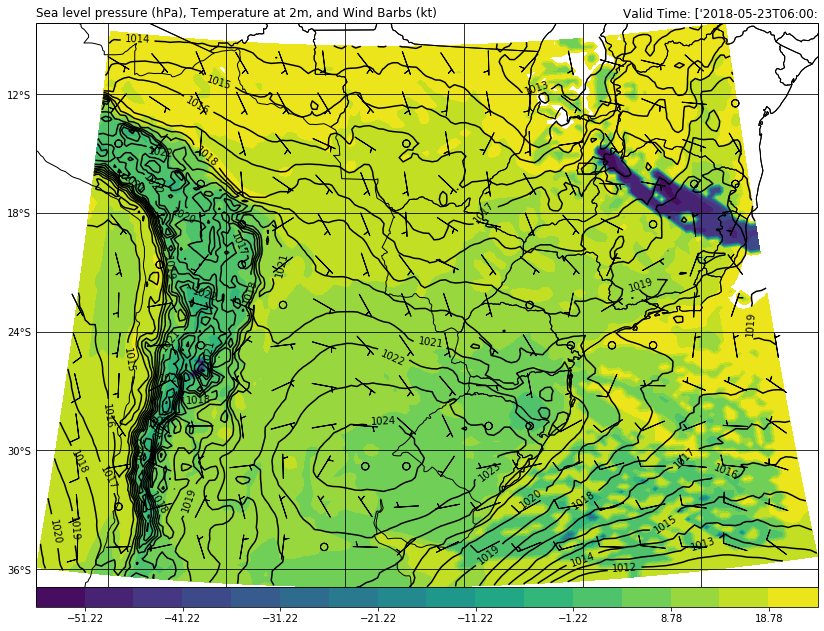

In [27]:
# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()
platecrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=platecrs)

# Add geopolitical boundaries for map reference
ax.add_feature(cf.COASTLINE.with_scale('50m'))
ax.add_feature(cf.STATES.with_scale('50m'))

# Plot 500-hPa Colorfill Wind Speeds in knots
clevs_ctt = np.arange(ctt.min().values,\
                           ctt.max().values, 5)
cfs = ax.contourf(lon, lat, ctt, clevs_ctt, #cmap=get_cmap('jet'), plt.cm.BuPu
                 transform=datacrs)
plt.colorbar(cfs, orientation='horizontal', pad=0, aspect=40)

# Plot 500-hPa Geopotential Heights in meters
clevs_slp = np.arange(slp.min().values,\
                           slp.max().values, 1)

cs = ax.contour(lon, lat, slp, clevs_slp, colors='black',
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 500-hPa wind barbs in knots, regrid to reduce number of barbs
ax.barbs(lon.values, lat.values, u_compont[0].values, v_compont[0].values, pivot='middle',
         color='black', regrid_shape=15, transform=datacrs)

# Make some nice titles for the plot (one right, one left)
plt.title('Sea level pressure (hPa), Temperature at 2m,'
          ' and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(str(t)[:19]), loc='right')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),color='black')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
plt.savefig('./slp_t2_dir.pdf')
plt.savefig('./slp_t2_dir.png')

# 500-hPa Geopotential Heights (m), Wind Speed (m/s), and Wind Barbs (kt) 

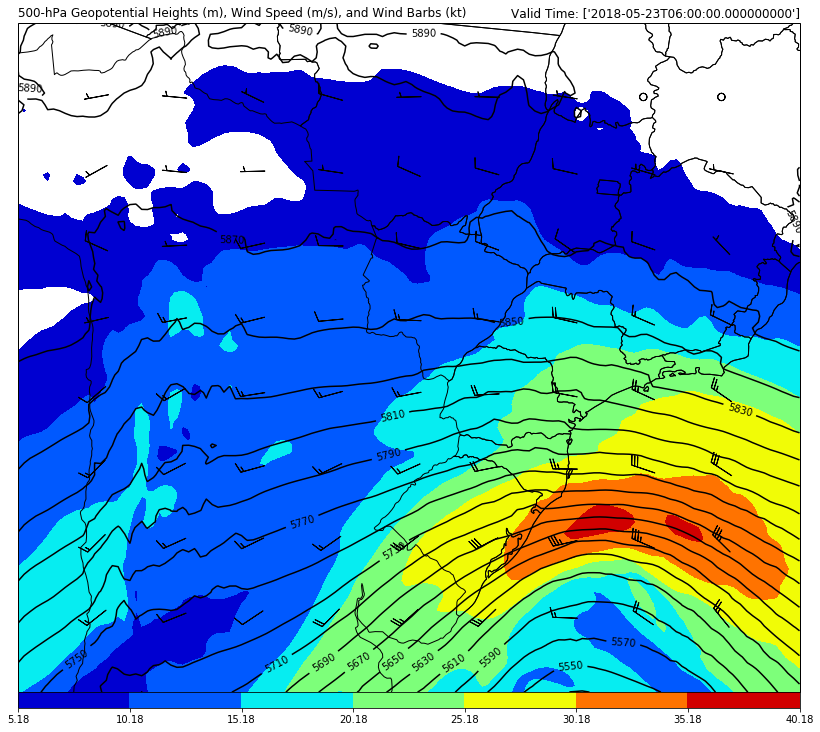

In [28]:
# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=cart_proj)

# Add geopolitical boundaries for map reference
ax.add_feature(cf.COASTLINE.with_scale('50m'))
ax.add_feature(cf.STATES.with_scale('50m'))

# Plot 500-hPa Colorfill Wind Speeds in knots
clevs_500_sped = np.arange(wspd_500.min().values+5,\
                           wspd_500.max().values+5, 5)
cfs = ax.contourf(lon, lat, wspd_500, clevs_500_sped, cmap=get_cmap('jet'),
                 transform=datacrs)
plt.colorbar(cfs, orientation='horizontal', pad=0, aspect=50)

# Plot 500-hPa Geopotential Heights in meters
clevs_500_hght = np.arange(h_500.min().values+1,\
                           h_500.max().values+1, 20)

cs = ax.contour(lon, lat, h_500, clevs_500_hght, colors='black',
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 500-hPa wind barbs in knots, regrid to reduce number of barbs
ax.barbs(lon.values, lat.values, u_500.values, v_500.values, pivot='middle',
         color='black', regrid_shape=10, transform=datacrs)

# Make some nice titles for the plot (one right, one left)
plt.title('500-hPa Geopotential Heights (m), Wind Speed (m/s),'
          ' and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(t), loc='right')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.savefig('./h_wspd_500.pdf')
plt.savefig('./h_wspd_500.png')

# Sea level pressure (hPa), Temperature at 2m, and Wind Barbs (kt)

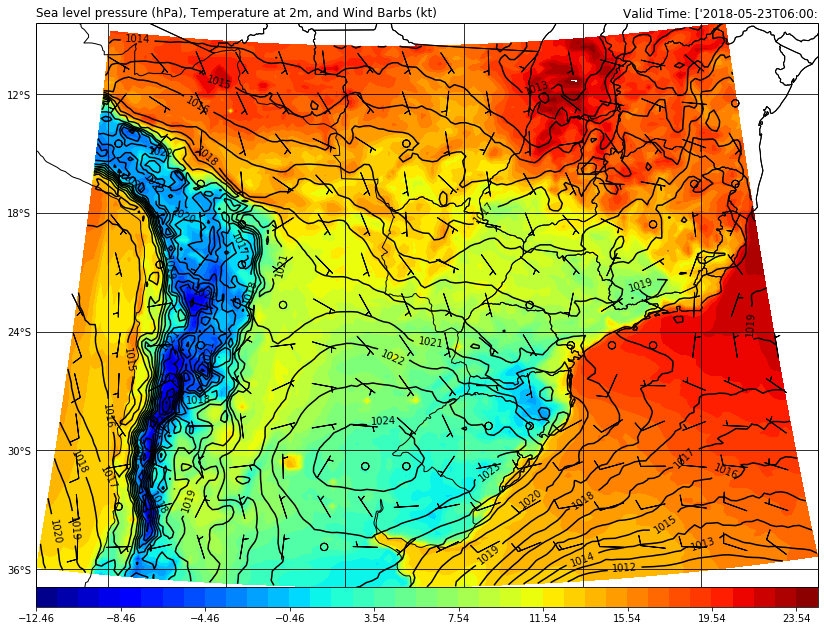

In [29]:
# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()
platecrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=platecrs)

# Add geopolitical boundaries for map reference
ax.add_feature(cf.COASTLINE.with_scale('50m'))
ax.add_feature(cf.STATES.with_scale('50m'))

# Plot 500-hPa Colorfill Wind Speeds in knots
clevs_t2m = np.arange(t2m.min().values-275.15,\
                           t2m.max().values-275.15, 1)
cfs = ax.contourf(lon, lat, t2m-275.15, clevs_t2m, cmap=get_cmap('jet'),
                 transform=datacrs)
plt.colorbar(cfs, orientation='horizontal', pad=0, aspect=40)

# Plot 500-hPa Geopotential Heights in meters
clevs_slp = np.arange(slp.min().values,\
                           slp.max().values, 1)

cs = ax.contour(lon, lat, slp, clevs_slp, colors='black',
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 500-hPa wind barbs in knots, regrid to reduce number of barbs
ax.barbs(lon.values, lat.values, u_compont[0].values, v_compont[0].values, pivot='middle',
         color='black', regrid_shape=15, transform=datacrs)

# Make some nice titles for the plot (one right, one left)
plt.title('Sea level pressure (hPa), Temperature at 2m,'
          ' and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(str(t)[:19]), loc='right')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),color='black')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
plt.savefig('./slp_t2m_dir2.pdf')
plt.savefig('./slp_t2m_dir2.png')

# Plotar temperatura de topo de nuvem e temperatura a 2m
### obs: colorbar muito grande 

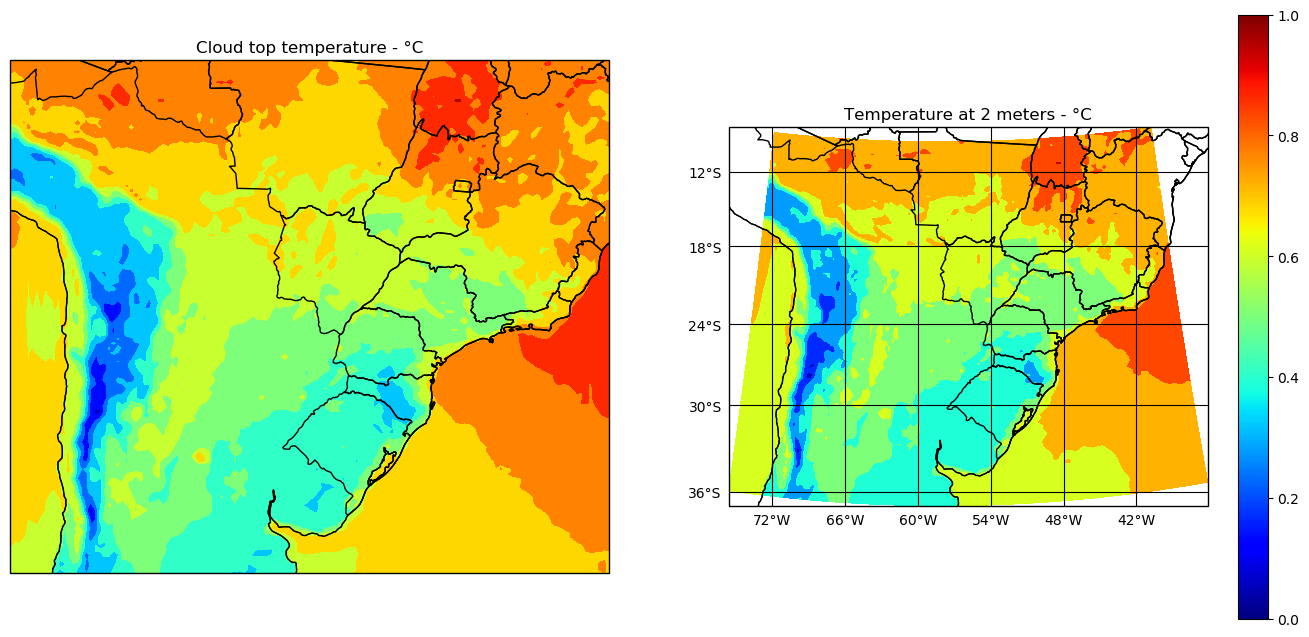

In [21]:
fig = plt.figure(figsize=(17,8),dpi=100)
gs = fig.add_gridspec(1, 2)

# 1° axe
ax1 = fig.add_subplot(gs[0, 0], projection=cart_proj)
ax1.coastlines('50m', linewidth=0.8)
ax1.contourf(to_np(lon), to_np(lat), to_np(t2m), 10, 
            transform=ccrs.PlateCarree(),cmap=get_cmap("jet"))
ax1.set_title('Cloud top temperature - °C')
# Add geopolitical boundaries for map reference
ax1.add_feature(cf.COASTLINE.with_scale('50m'))
ax1.add_feature(cf.STATES.with_scale('50m'))

# 2° axe
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.Mercator())
ax2.coastlines('50m', linewidth=0.8)
ax2.contourf(to_np(lon), to_np(lat), to_np(t2m),\
            level=np.arange(0, 30,20),  cmap=get_cmap("jet"),
            transform=ccrs.PlateCarree())
ax2.set_title('Temperature at 2 meters - °C')
# Add geopolitical boundaries for map reference
ax2.add_feature(cf.COASTLINE.with_scale('50m'))
ax2.add_feature(cf.STATES.with_scale('50m'))
# draw gridlines for ax2
gl = ax2.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),color='black')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False


# colorbar for ax2
sm = plt.cm.ScalarMappable(cmap=get_cmap("jet"))
cb = plt.colorbar(sm)


plt.ticklabel_format()